In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
data_dir = 'TestSet'

batch_size = 32
epochs = 8
workers = 0 if os.name == 'nt' else 8

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [3]:
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]
    

In [4]:
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

# Model

In [5]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

In [6]:
resnet.load_state_dict(torch.load('GeorgiaTech-TestDataset_StateDict.pth'))

<All keys matched successfully>

# Test DataLoader

In [7]:
trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
img_inds = np.arange(len(dataset))

test_loader = DataLoader( 
    dataset,
    num_workers=workers,
    batch_size=1,
)

In [8]:
x, y = next(iter(test_loader))

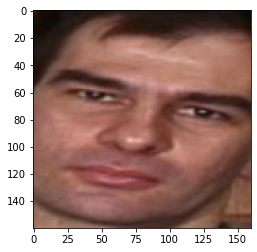

In [9]:
import torchvision.utils as utils
import matplotlib.pyplot as plt
plt.imshow(np.transpose(utils.make_grid(x.detach().cpu(), padding=2, normalize=True),(1,2,0)))

In [10]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
) 

In [11]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder(data_dir + '_cropped')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [12]:
dataset.idx_to_class

{0: 'P1',
 1: 'P10',
 2: 'P11',
 3: 'P12',
 4: 'P13',
 5: 'P14',
 6: 'P15',
 7: 'P16',
 8: 'P17',
 9: 'P18',
 10: 'P19',
 11: 'P2',
 12: 'P20',
 13: 'P21',
 14: 'P22',
 15: 'P23',
 16: 'P24',
 17: 'P25',
 18: 'P26',
 19: 'P27',
 20: 'P28',
 21: 'P29',
 22: 'P3',
 23: 'P30',
 24: 'P31',
 25: 'P32',
 26: 'P33',
 27: 'P34',
 28: 'P35',
 29: 'P36',
 30: 'P37',
 31: 'P38',
 32: 'P39',
 33: 'P4',
 34: 'P40',
 35: 'P41',
 36: 'P42',
 37: 'P43',
 38: 'P44',
 39: 'P45',
 40: 'P46',
 41: 'P47',
 42: 'P48',
 43: 'P49',
 44: 'P5',
 45: 'P50',
 46: 'P6',
 47: 'P7',
 48: 'P8',
 49: 'P9'}

# Processing

In [12]:
import cv2
import mediapipe as mp
import numpy as np
from math import hypot
from imutils import paths
import os

In [13]:
def get_landmarks(location, frame_patch_width, frame_patch_height, global_patch_width, facial_landmarks):

     # Nose Co-ordinates
        if location == 'Nose':
            top = (facial_landmarks.landmark[8].x * frame_patch_width, facial_landmarks.landmark[8].y * frame_patch_height)
            center = (facial_landmarks.landmark[195].x * frame_patch_width, facial_landmarks.landmark[195].y * frame_patch_height)

            left_point = (facial_landmarks.landmark[190].x * frame_patch_width, facial_landmarks.landmark[190].y * frame_patch_height)
            right_point = (facial_landmarks.landmark[413].x * frame_patch_width, facial_landmarks.landmark[413].y * frame_patch_height)

            # patch_width = int(hypot(left_point[0] - right_point[0],
            #                     left_point[1] - right_point[1]))

            patch_width = global_patch_width
            patch_height = int(patch_width)                      

            top_left = (int(center[0] - patch_width / 2),
                            int(center[1] - patch_height /2))

            bottom_right = (int(center[0] + patch_width / 2),
                                int(center[1] + patch_height / 2))
            
        # EyeBrow Coordinates
        if location == 'Eyebrow':
            #top = (facial_landmarks.landmark[71].x * patch_width, facial_landmarks.landmark[71].y * patch_height)
            center = (facial_landmarks.landmark[69].x * frame_patch_width, facial_landmarks.landmark[69].y * frame_patch_height)

            left_point = (facial_landmarks.landmark[71].x * frame_patch_width, facial_landmarks.landmark[71].y * frame_patch_height)
            right_point = (facial_landmarks.landmark[108].x * frame_patch_width, facial_landmarks.landmark[108].y * frame_patch_height)

            #patch_width = int(hypot(left_point[0] - right_point[0],
            #                     left_point[1] - right_point[1]))

            patch_width = global_patch_width
            patch_height = int(patch_width)                      

            top_left = (int(center[0] - patch_width / 2),
                            int(center[1] - patch_height /2))

            bottom_right = (int(center[0] + patch_width / 2),
                                int(center[1] + patch_height / 2))


        # Chin Coordinates
        if location == 'Chin':
            center = (facial_landmarks.landmark[199].x * frame_patch_width, facial_landmarks.landmark[199].y * frame_patch_height)

            left_point = (facial_landmarks.landmark[140].x * frame_patch_width, facial_landmarks.landmark[140].y * frame_patch_height)
            right_point = (facial_landmarks.landmark[428].x * frame_patch_width, facial_landmarks.landmark[428].y * frame_patch_height)

            # patch_width = int(hypot(left_point[0] - right_point[0],
            #                     left_point[1] - right_point[1]))

            patch_width = global_patch_width
            patch_height = int(patch_width)                      

            top_left = (int(center[0] - patch_width / 2),
                            int(center[1] - patch_height /2))

            bottom_right = (int(center[0] + patch_width / 2),
                                int(center[1] + patch_height / 2))
            
        # Cheek Coordinates
        if location == 'Cheek':
            center = (facial_landmarks.landmark[205].x * frame_patch_width, facial_landmarks.landmark[205].y * frame_patch_height)

            # patch_width = int(hypot(left_point[0] - right_point[0],
            #                     left_point[1] - right_point[1]))

            patch_width = global_patch_width
            patch_height = int(patch_width)                      

            top_left = (int(center[0] - patch_width / 2),
                            int(center[1] - patch_height /2))


            
            
        return patch_width, patch_height, top_left

In [14]:
def get_multi_landmarks(location, frame_width, frame_height, target_patch_size_w, target_patch_size_h, facial_landmarks):

    if location == 'N-C-C':  # NOSE-CHEEK-CHIN
        ## NOSE

        nose_center = (facial_landmarks.landmark[195].x * frame_width, facial_landmarks.landmark[195].y * frame_height)

        nose_patch_width = target_patch_size_w
        nose_patch_height = target_patch_size_h                      

        nose_top_left = (int(nose_center[0] - nose_patch_width / 2),
                        int(nose_center[1] - nose_patch_height /2))            

        ## CHEEK 
        cheek_center = (facial_landmarks.landmark[205].x * frame_width, facial_landmarks.landmark[205].y * frame_height)

        cheek_patch_width = target_patch_size_w
        cheek_patch_height = target_patch_size_h                      

        cheek_top_left = (int(cheek_center[0] - cheek_patch_width / 2),
                        int(cheek_center[1] - cheek_patch_height /2))

        ## CHIN
        chin_center = (facial_landmarks.landmark[199].x * frame_width, facial_landmarks.landmark[199].y * frame_height)

        chin_patch_width = target_patch_size_w
        chin_patch_height = target_patch_size_h                      

        chin_top_left = (int(chin_center[0] - chin_patch_width / 2),
                        int(chin_center[1] - chin_patch_height /2))

    return nose_patch_width, nose_patch_height, nose_top_left, cheek_patch_width, cheek_patch_height, cheek_top_left, chin_patch_width, chin_patch_height, chin_top_left

In [15]:
# Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh() 

In [16]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    
    noise_matrix = epsilon*sign_data_grad
    #torch.save(noise_matrix, "NoiseMatrix_{0}.pth".format(eps_value))
    return perturbed_image, noise_matrix

loss_fn = torch.nn.CrossEntropyLoss()

In [12]:
frame = cv2.imread('TestSet_cropped/P17/s17_13.jpg')

frame_patch_height, frame_patch_width, _ = frame.shape

result = face_mesh.process(frame)


In [18]:
aligned = []
x_aligned, prob = mtcnn(frame, return_prob=True)
aligned.append(x_aligned)

C:\Users\Rushiraj\AppData\Roaming\Python\Python38\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [19]:
resnet.eval()

faces = torch.stack(aligned).to(device)
x = faces.to(device)
y = torch.tensor([17]).to(device)
x.requires_grad = True

y_pred = resnet(x)
loss_batch = loss_fn(y_pred, y)

resnet.zero_grad()
loss_batch.backward()

data_grad = x.grad.data 

perturbed_data, noise_matrix = fgsm_attack(x, 0.05, data_grad)

## Sanity Check - Frame and Tensor

In [29]:
#init_pred, preds = y_pred.max(1, keepdim=True)
init_pred, preds = torch.max(y_pred, 1)
preds = preds.detach().cpu().numpy() 
print([dataset.idx_to_class[p] for p in preds])
init_pred.item()

['P1']


11.397555351257324

In [20]:
#init_pred, preds = y_pred.max(1, keepdim=True)
init_pred, preds = torch.max(y_pred, 1)
preds = preds.detach().cpu().numpy() 
print([dataset.idx_to_class[p] for p in preds])
init_pred.item()

['P20']


5.311098575592041

#### Only converting to Tensor - doesnt work

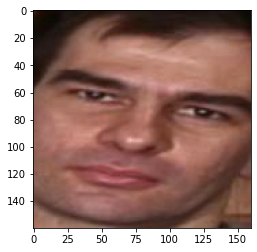

In [39]:
#plt.imshow(frame)
#plt.imshow(np.transpose(utils.make_grid(img.detach().cpu(), padding=2, normalize=False),(1,2,0)))

In [41]:
from torchvision import transforms
trans = transforms.Compose([transforms.ToTensor()])

img = trans(frame)
image = img.unsqueeze(0).cuda()

In [21]:
output = resnet(image)
        
final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
final_pred

tensor([[39]], device='cuda:0')

#### MTCNN and stack it - WORKS

In [22]:
aligned = []
x_aligned, prob = mtcnn(frame, return_prob=True)
aligned.append(x_aligned)

[tensor([], device='cuda:0', size=(0, 9)), tensor([[ 3.5000e+01,  4.9000e+01,  6.1000e+01,  7.5000e+01,  6.9714e-01,
         -1.6476e-01, -1.1630e-01,  8.6672e-02,  3.4223e-01],
        [ 3.9000e+01,  4.9000e+01,  6.5000e+01,  7.5000e+01,  6.4452e-01,
         -2.0727e-01, -1.2272e-01,  5.4138e-02,  3.1397e-01],
        [ 4.4000e+01,  4.9000e+01,  7.0000e+01,  7.5000e+01,  6.8794e-01,
         -2.4154e-01, -1.5871e-01,  1.0310e-02,  2.5796e-01],
        [ 3.9000e+01,  5.4000e+01,  6.5000e+01,  7.9000e+01,  7.2244e-01,
         -2.2229e-01, -1.3517e-01,  3.2408e-02,  2.6315e-01],
        [ 5.8000e+01,  1.2400e+02,  8.4000e+01,  1.5000e+02,  7.3051e-01,
         -1.5494e-01, -1.0746e-01, -9.2677e-03,  1.6921e-01],
        [ 6.3000e+01,  1.2400e+02,  8.9000e+01,  1.5000e+02,  6.1743e-01,
         -1.6635e-01, -1.0335e-01, -3.3053e-02,  1.7303e-01],
        [ 5.8000e+01,  1.2900e+02,  8.4000e+01,  1.5500e+02,  6.5891e-01,
         -1.9762e-01, -2.6733e-01,  2.9119e-02,  1.0315e-01]], devi

In [25]:

#faces = faces.to(device)
faces = torch.stack(aligned).to(device)

outputs = resnet(faces)
dist, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy() 
print(dist, preds)
print([dataset.idx_to_class[p] for p in preds])

tensor([11.6324], device='cuda:0', grad_fn=<MaxBackward0>) [0]
['P1']


# Add Noise

In [17]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    
    noise_matrix = epsilon*sign_data_grad
    #torch.save(noise_matrix, "NoiseMatrix_{0}.pth".format(eps_value))
    return perturbed_image, noise_matrix

loss_fn = torch.nn.CrossEntropyLoss()

In [18]:
x, y = next(iter(test_loader))

In [19]:
frame = x[0].detach().cpu().numpy()
frame = np.transpose(frame, (1,2,0))
frame = cv2.normalize(src=frame, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) ## V.V.IMP!!

frame_height, frame_width, _ = frame.shape

result = face_mesh.process(frame)

In [20]:
resnet.eval()

x = x.to(device)
y = y.to(device)
x.requires_grad = True

y_pred = resnet(x)
loss_batch = loss_fn(y_pred, y)

resnet.zero_grad()
loss_batch.backward()

data_grad = x.grad.data 

perturbed_data, noise_matrix = fgsm_attack(x, 1, data_grad)

C:\Users\Rushiraj\AppData\Roaming\Python\Python38\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [21]:
#init_pred, preds = y_pred.max(1, keepdim=True)
init_pred, preds = torch.max(y_pred, 1)
preds = preds.detach().cpu().numpy() 
print([dataset.idx_to_class[p] for p in preds])
init_pred.item()

['P1']


12.265685081481934

(60, 60, 3)
Adding the Band Aid


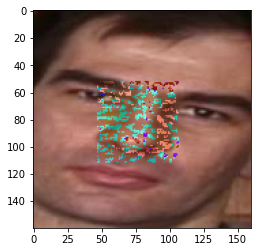

In [22]:
location = 'Nose'
target_patch_size_w, target_patch_size_h = 60, 60

bd_image = cv2.imread("BD.jpeg")
bd_image = cv2.cvtColor(bd_image, cv2.COLOR_BGR2RGB)

patch = True

for facial_landmarks in result.multi_face_landmarks:
    
    if location == 'N-C-C':
        
        nose_patch_width, nose_patch_height, nose_top_left, cheek_patch_width, cheek_patch_height, cheek_top_left, chin_patch_width, chin_patch_height, chin_top_left = get_multi_landmarks(location, frame_width, frame_height, 
                                                                            target_patch_size_w, target_patch_size_h, facial_landmarks)
        
        np_img = noise_matrix[0].detach().cpu().numpy() # SIZE of our IMAGE
        np_img = np.transpose(np_img, (1,2,0))
        


        #################################################### Processing for NOSE ######################################################################



        nose_area = np_img[nose_top_left[1]: nose_top_left[1] + nose_patch_height,
                    nose_top_left[0]: nose_top_left[0] + nose_patch_width]
        
        if patch:

            bd_image_nose = cv2.resize(bd_image, (nose_area.shape[1], nose_area.shape[0]))

            noisy_patch_nose = bd_image_nose + bd_image_nose * nose_area
            noisy_patch_nose = noisy_patch_nose.clip(0, 255)

             # Adding the Band Aid Image
            bd_pic_nose = cv2.resize(noisy_patch_nose, (nose_patch_width, nose_patch_height))
            bd_pic_nose_gray = cv2.cvtColor(bd_pic_nose, cv2.COLOR_BGR2GRAY)
            _, mask = cv2.threshold(bd_pic_nose_gray, 25, 255, cv2.THRESH_BINARY_INV)

            mask = mask.astype(np.uint8)
            bd_pic_nose = bd_pic_nose.astype(np.uint8)

            print("NOSE - ", nose_area.shape, mask.shape)

            nose_area_no_nose = cv2.bitwise_and(nose_area, nose_area, mask=mask)

            #print(nose_area_no_nose.shape, bd_pic_nose.shape)
            
            nose_area_no_nose = nose_area_no_nose.astype(np.uint8)
            
            nose_final_loc = cv2.add(nose_area_no_nose, bd_pic_nose)
            nose_final_loc = cv2.cvtColor(nose_final_loc, cv2.COLOR_BGR2RGB)

            frame[nose_top_left[1]: nose_top_left[1] + nose_patch_height,
                        nose_top_left[0]: nose_top_left[0] + nose_patch_width] = frame[nose_top_left[1]: nose_top_left[1] + nose_patch_height,
                        nose_top_left[0]: nose_top_left[0] + nose_patch_width] + nose_final_loc
            

        else:
            frame[nose_top_left[1]: nose_top_left[1] + nose_patch_height,
                        nose_top_left[0]: nose_top_left[0] + nose_patch_width] = frame[nose_top_left[1]: nose_top_left[1] + nose_patch_height,
                        nose_top_left[0]: nose_top_left[0] + nose_patch_width] + nose_area

        ###################################################### Processing for CHEEK ####################################################################


        cheek_area = np_img[cheek_top_left[1]: cheek_top_left[1] + cheek_patch_height,
                    cheek_top_left[0]: cheek_top_left[0] + cheek_patch_width]
        
        if patch:
            bd_image_cheek = cv2.resize(bd_image, (cheek_area.shape[1], cheek_area.shape[0]))

            noisy_patch_cheek = bd_image_cheek + bd_image_cheek * cheek_area
            noisy_patch_cheek = noisy_patch_cheek.clip(0, 255)

             # Adding the Band Aid Image
            bd_pic_cheek = cv2.resize(noisy_patch_cheek, (cheek_patch_width, cheek_patch_height))
            bd_pic_cheek_gray = cv2.cvtColor(bd_pic_cheek, cv2.COLOR_BGR2GRAY)
            _, mask = cv2.threshold(bd_pic_cheek_gray, 25, 255, cv2.THRESH_BINARY_INV)

            mask = mask.astype(np.uint8)
            bd_pic_cheek = bd_pic_cheek.astype(np.uint8)

            print("CHEEK - ", cheek_area.shape, mask.shape)

            cheek_area_no_cheek = cv2.bitwise_and(cheek_area, cheek_area, mask=mask)
            
            cheek_area_no_cheek = cheek_area_no_cheek.astype(np.uint8)

            cheek_final_loc = cv2.add(cheek_area_no_cheek, bd_pic_cheek)
            cheek_final_loc = cv2.cvtColor(cheek_final_loc, cv2.COLOR_BGR2RGB)

            frame[cheek_top_left[1]: cheek_top_left[1] + cheek_patch_height,
                        cheek_top_left[0]: cheek_top_left[0] + cheek_patch_width] = frame[cheek_top_left[1]: cheek_top_left[1] + cheek_patch_height,
                        cheek_top_left[0]: cheek_top_left[0] + cheek_patch_width] + cheek_final_loc
        
        else:
            frame[cheek_top_left[1]: cheek_top_left[1] + cheek_patch_height,
                        cheek_top_left[0]: cheek_top_left[0] + cheek_patch_width] = frame[cheek_top_left[1]: cheek_top_left[1] + cheek_patch_height,
                        cheek_top_left[0]: cheek_top_left[0] + cheek_patch_width] + cheek_area


        ####################################################### Processing for CHIN #########################################################################
        chin_area = np_img[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                        chin_top_left[0]: chin_top_left[0] + chin_patch_width]

        chin_area = cv2.resize(chin_area, (mask.shape[1], mask.shape[0]))
        
        if patch:
            bd_image_chin = cv2.resize(bd_image, (nose_area.shape[1], nose_area.shape[0]))

            noisy_patch_chin = bd_image_chin + bd_image_chin * chin_area
            noisy_patch_chin = noisy_patch_cheek.clip(0, 255)

             # Adding the Band Aid Image
            bd_pic_chin = cv2.resize(noisy_patch_chin, (chin_patch_width, chin_patch_height))
            bd_pic_chin_gray = cv2.cvtColor(bd_pic_chin, cv2.COLOR_BGR2GRAY)
            _, mask = cv2.threshold(bd_pic_chin_gray, 25, 255, cv2.THRESH_BINARY_INV)

            mask = mask.astype(np.uint8)
            bd_pic_chin = bd_pic_chin.astype(np.uint8)
            

            print("CHIN - ", chin_area.shape, mask.shape)

            chin_area_no_chin = cv2.bitwise_and(chin_area, chin_area, mask=mask)
            
            chin_area_no_chin = chin_area_no_chin.astype(np.uint8)

            chin_final_loc = cv2.add(chin_area_no_chin, bd_pic_chin)
            x, y = frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                        chin_top_left[0]: chin_top_left[0] + chin_patch_width].shape[1], frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                        chin_top_left[0]: chin_top_left[0] + chin_patch_width].shape[0]

            chin_final_loc = cv2.resize(chin_final_loc, (x, y))
            chin_final_loc = cv2.cvtColor(chin_final_loc, cv2.COLOR_BGR2RGB)

            frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                        chin_top_left[0]: chin_top_left[0] + chin_patch_width] = frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                        chin_top_left[0]: chin_top_left[0] + chin_patch_width] + chin_final_loc
            
            plt.imshow(frame)
        else:
            frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                        chin_top_left[0]: chin_top_left[0] + chin_patch_width] = frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                        chin_top_left[0]: chin_top_left[0] + chin_patch_width] + chin_final_loc
    
    
    else:
        global_patch_width = target_patch_size_w
        patch_width, patch_height, top_left = get_landmarks(location, frame_width, frame_height, global_patch_width, facial_landmarks)

        np_img = noise_matrix[0].detach().cpu().numpy() # SIZE of our IMAGE
        np_img = np.transpose(np_img, (1,2,0))

        reqd_matrix = np_img[top_left[1]: top_left[1] + patch_height,
                    top_left[0]: top_left[0] + patch_width]
        
        print(reqd_matrix.shape)

        if patch:

            print("Adding the Band Aid")
            bd_image = cv2.resize(bd_image, (reqd_matrix.shape[1], reqd_matrix.shape[0]))

            noisy_patch = bd_image + bd_image * reqd_matrix
            noisy_patch = noisy_patch.clip(0, 255)

             # Adding the Band Aid Image
            bd_pic = cv2.resize(noisy_patch, (patch_width, patch_height))
            bd_pic_gray = cv2.cvtColor(bd_pic, cv2.COLOR_BGR2GRAY)
            _, mask = cv2.threshold(bd_pic_gray, 25, 255, cv2.THRESH_BINARY_INV)

            location_area = frame[top_left[1]: top_left[1] + patch_height,
                        top_left[0]: top_left[0] + patch_width]

            mask = mask.astype(np.uint8)
            bd_pic = bd_pic.astype(np.uint8)

            location_area_no_loc = cv2.bitwise_and(location_area, location_area, mask=mask)

            final_nose = cv2.add(location_area_no_loc, bd_pic)

            frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width] = frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width] + final_nose

            plt.imshow(final_nose)
            plt.imshow(frame)


        else:
            frame[top_left[1]: top_left[1] + patch_height,
                    top_left[0]: top_left[0] + patch_width] = frame[top_left[1]: top_left[1] + patch_height,
                    top_left[0]: top_left[0] + patch_width] + reqd_matrix

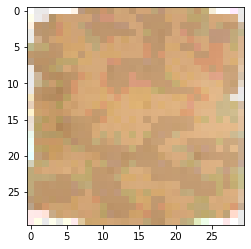

In [35]:
plt.imshow(final_nose)

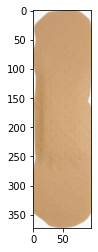

In [36]:
bd_image = cv2.imread("BD.jpeg")
bd_image = cv2.cvtColor(bd_image, cv2.COLOR_BGR2RGB)
plt.imshow(bd_image)

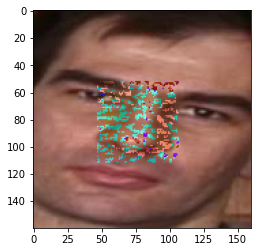

In [23]:
plt.imshow(frame)

In [25]:
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cv2.imwrite("Nose-60x60.png", frame)

True

In [106]:
aligned = []
x_aligned, prob = mtcnn(frame, return_prob=True)
aligned.append(x_aligned)


In [107]:
#faces = faces.to(device)
faces = torch.stack(aligned).to(device)

outputs = resnet(faces)
dist, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy() 
print(dist, preds)
print([dataset.idx_to_class[p] for p in preds])

tensor([11.8926], device='cuda:0', grad_fn=<MaxBackward0>) [0]
['P1']


In [108]:
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cv2.imwrite("Eps-0.05-NO-BD-3-Locations.png", frame)

True

## Random Image

In [44]:
frame = cv2.imread('TestSet_cropped/P17/s17_12.jpg')
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

frame_patch_height, frame_patch_width, _ = frame.shape

result = face_mesh.process(frame)

In [45]:
aligned = []
x_aligned, prob = mtcnn(frame, return_prob=True)
aligned.append(x_aligned)

In [46]:
resnet.eval()

faces = torch.stack(aligned).to(device)
x = faces.to(device)
y = torch.tensor([17]).to(device)
x.requires_grad = True

y_pred = resnet(x)
loss_batch = loss_fn(y_pred, y)

resnet.zero_grad()
loss_batch.backward()

data_grad = x.grad.data 

perturbed_data, noise_matrix = fgsm_attack(x, 0.05, data_grad)

In [47]:
#init_pred, preds = y_pred.max(1, keepdim=True)
init_pred, preds = torch.max(y_pred, 1)
preds = preds.detach().cpu().numpy() 
print([dataset.idx_to_class[p] for p in preds])
init_pred.item()

['P17']


11.620388984680176

In [48]:
patch = True
location = 'Chin'
global_patch_width = 30
bd_image = cv2.imread("BD.jpeg")
bd_image = cv2.cvtColor(bd_image, cv2.COLOR_BGR2RGB)

for facial_landmarks in result.multi_face_landmarks:
    
    patch_width, patch_height, top_left = get_landmarks(location, frame_patch_width, frame_patch_height, global_patch_width, facial_landmarks)

    np_img = noise_matrix[0].detach().cpu().numpy()
    np_img = np.transpose(np_img, (1,2,0))

    reqd_matrix = np_img[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width]

    if patch:

        bd_image = cv2.resize(bd_image, (reqd_matrix.shape[1], reqd_matrix.shape[0]))

        noisy_patch = bd_image + bd_image * reqd_matrix
        noisy_patch = noisy_patch.clip(0, 255)

         # Adding the Band Aid Image
        bd_pic = cv2.resize(noisy_patch, (patch_width, patch_height))
        bd_pic_gray = cv2.cvtColor(bd_pic, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(bd_pic_gray, 25, 255, cv2.THRESH_BINARY_INV)

        location_area = frame[top_left[1]: top_left[1] + patch_height,
                    top_left[0]: top_left[0] + patch_width]

        if mask.shape != location_area.shape:
            mask = cv2.resize(mask, (location_area.shape[1], location_area.shape[0]))

        mask = mask.astype(np.uint8)
        bd_pic = bd_pic.astype(np.uint8)

        try:
            location_area_no_loc = cv2.bitwise_and(location_area, location_area, mask=mask)
        except:
            print("Mask Shape - ", mask.shape, "Location shape - ", location_area.shape)

        bd_pic = cv2.resize(bd_pic, (location_area_no_loc.shape[1], location_area_no_loc.shape[0]))
        final_nose = cv2.add(location_area_no_loc, bd_pic)
        final_nose = cv2.cvtColor(final_nose, cv2.COLOR_BGR2RGB)

        frame[top_left[1]: top_left[1] + patch_height,
            top_left[0]: top_left[0] + patch_width] = frame[top_left[1]: top_left[1] + patch_height,
            top_left[0]: top_left[0] + patch_width] + final_nose

    else:
        frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width] = frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width] + reqd_matrix

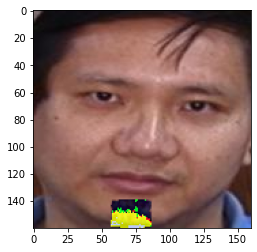

In [49]:
plt.imshow(frame)

In [51]:
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cv2.imwrite("ChinPatch.png", frame)

True